# Add an Image: Productivity during the first 24 hours

We investigate the effect of having Add an Image as the default task on the number of edits a newcomer makes during the first 24 hours after registration, also referred to as the "activation" period.

In [1]:
library(tidyverse)
library(broom)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

#library(lme4)
#library(yardstick) # install.packages("yardstick")

#library(caret)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-an-image-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add an Image on each of the wikis
## This is not relevant for this, because we "reset" the experiment and
## gather data well after deployment.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 148419

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [9]:
user_edit_data <- user_edit_data %>%
    mutate(
        platform = ifelse(reg_on_mobile == 1, 'Mobile web', 'Desktop'),
        exp_group = factor(
            ifelse(
                hp_enabled == 0, 'Control',
                ifelse(hp_variant == 'control',
                       'Add-a-Link', 'Add-an-Image')
            ),
            c('Control', 'Add-a-Link', 'Add-an-Image')
        )
    )

Our productivity model will fit on the total number of constructive article edits during the first 24 hours, so we need a variable for that.

In [10]:
user_edit_data <- user_edit_data %>%
    mutate(num_const_article_edits_24hrs = num_article_edits_24hrs - num_article_reverts_24hrs)

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_edit_data %>%
    group_by(wiki_db, exp_group) %>%
    summarize(n = n())

## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

## Visualizing Productivity

We'll make box plots of editing based on group, and we'll focus on constructive article edits because that's where we see the strongest effects. This plot uses the `log10(1 + x)` transformation so we get to see all users who didn't make any edits.

In [ ]:
user_edit_data %>%
    mutate(log_num_const_article_edits_24hrs = log10(1 + num_const_article_edits_24hrs)) %>%
    ggplot(aes(x = exp_group, y = log_num_const_article_edits_24hrs)) +
        labs(title = 'Productivity by Group', yaxis_title = 'Number of constructive edits (log 10 scale)') +
        geom_boxplot()

It looks like these groups are largely similar, let's summarize and see what we find.

In [ ]:
user_edit_data %>%
    group_by(platform, exp_group) %>%
    summarise(min_edits = min(num_const_article_edits_24hrs),
              perc_5_edits = quantile(num_const_article_edits_24hrs, probs = c(0.05)),
              perc_10_edits = quantile(num_const_article_edits_24hrs, probs = c(0.1)),
              perc_25_edits = quantile(num_const_article_edits_24hrs, probs = c(0.25)),
              median_edits = median(num_const_article_edits_24hrs),
              mean_edits = mean(num_const_article_edits_24hrs),
              perc_75_edits = quantile(num_const_article_edits_24hrs, probs = c(0.75)),
              perc_90_edits = quantile(num_const_article_edits_24hrs, probs = c(0.9)),
              perc_95_edits = quantile(num_const_article_edits_24hrs, probs = c(0.95)),
              max_edits = max(num_const_article_edits_24hrs),
             .groups = 'keep'
             )

## Priors

In [15]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

# Constructive Article Productivity with Group-level Variation

In the analysis of activation, we found meaningful group-level variation in `platform`. We also saw platform-specific differences in the effect of `exp_group`. There did not appear to be group-level variation in `exp_group`. This leads us to fit a model that on the population level has interaction between both variables, and that on the group level allows for variation in `platform`.

In [ ]:
constr.article.edits.24hrs.zinb.1 <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform * exp_group +
      (1 + platform | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, wiki_db != 'frwiki'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 400,
    control = list(adapt_delta = 0.99,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.1,
     file='models/constr.article.edits.24hrs.zinb.1.Robj')

In [18]:
summary(constr.article.edits.24hrs.zinb.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_const_article_edits_24hrs ~ platform * exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki") (Number of observations: 110389) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Group-Level Effects: 
~wiki_db (Number of levels: 6) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.55      0.24     0.27     1.17
sd(platformMobileweb)                      0.35      0.14     0.16     0.75
sd(zi_Intercept)                           3.45      1.01     1.95     6.02
sd(zi_platformMobileweb)                   2.59      0.86     1.33     4.70
cor(Intercept,platformMobileweb)          -0.56      0.32    -0.94     0.30
cor(zi_Intercept,zi_platformMobileweb)    -0.85      0.19    -0.99    -0.

In [ ]:
fixef(constr.article.edits.24hrs.zinb.1)

In [ ]:
print(ranef(constr.article.edits.24hrs.zinb.1))

For the other productivity models, we've seen that group-level variation in `platform` for zero-inflation has largely been zero. In this case it looks like there might be meaningful signal here since the 95% credible intervals fluctuate quite a bit, and so we keep it.

It's also clear that there's interaction going on between `platform` and `exp_group`. We'll next fit a model that also has group-level variation in that interaction effect.

Getting the incident rate for Add a Link, with the 95% credible interval:

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Estimate"])

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Q2.5"])

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Q97.5"])

Similar incident rate for Add a Link on mobile:

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Estimate"] + 
    fixef(constr.article.edits.24hrs.zinb.1)[7,"Estimate"])

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Q2.5"] + 
    fixef(constr.article.edits.24hrs.zinb.1)[7,"Q2.5"])

In [ ]:
exp(fixef(constr.article.edits.24hrs.zinb.1)[5,"Q97.5"] + 
    fixef(constr.article.edits.24hrs.zinb.1)[7,"Q97.5"])

Let's use the geometric mean to calculate the increase this time:

In [70]:
control.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Control",]$num_const_article_edits_24hrs
        )
    )
) - 1
round(control.geomean, 3)

[1] 0.251

In [71]:
unstructured.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Unstructured",]$num_const_article_edits_24hrs
        )
    )
) - 1
round(unstructured.geomean, 3)

[1] 0.264

In [72]:
addalink.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Add-a-link",]$num_const_article_edits_24hrs
        )
    )
) - 1
round(addalink.geomean, 3)

[1] 0.304

In [73]:
round(unstructured.geomean - control.geomean, 3)

[1] 0.013

In [74]:
round(addalink.geomean - control.geomean, 3)

[1] 0.052

In [68]:
round(100 * (unstructured.geomean - control.geomean) / control.geomean, 1)

[1] 5.1

In [69]:
round(100 * (addalink.geomean - control.geomean) / control.geomean, 1)

[1] 20.9

In [ ]:
pp_check(constr.article.edits.24hrs.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10));

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

In [ ]:
pp_check(constr.article.edits.24hrs.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 5000));

## Statistics split by platform

In [16]:
control.desktop.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Control" &
                                user_edit_data$platform == 'desktop'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(control.desktop.geomean, 3)

[1] 0.309

In [18]:
unstructured.desktop.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Unstructured" &
                                user_edit_data$platform == 'desktop'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(unstructured.desktop.geomean, 3)

[1] 0.328

In [26]:
addalink.desktop.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Add-a-link" &
                                user_edit_data$platform == 'desktop'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(addalink.desktop.geomean, 3)

[1] 0.361

In [29]:
round(unstructured.desktop.geomean - control.desktop.geomean, 3)

[1] 0.018

In [27]:
round(addalink.desktop.geomean - control.desktop.geomean, 3)

[1] 0.052

In [30]:
round(100 * (unstructured.desktop.geomean - control.desktop.geomean) / control.desktop.geomean, 1)

[1] 6

In [31]:
round(100 * (addalink.desktop.geomean - control.desktop.geomean) / control.desktop.geomean, 1)

[1] 16.7

In [21]:
control.mobile.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Control" &
                                user_edit_data$platform == 'mobile'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(control.mobile.geomean, 3)

[1] 0.199

In [22]:
unstructured.mobile.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Unstructured" &
                                user_edit_data$platform == 'mobile'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(unstructured.mobile.geomean, 3)

[1] 0.205

In [23]:
addalink.mobile.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[(user_edit_data$Group == "Add-a-link" &
                                user_edit_data$platform == 'mobile'),]$num_const_article_edits_24hrs
        )
    )
) - 1
round(addalink.mobile.geomean, 3)

[1] 0.25

In [32]:
round(unstructured.mobile.geomean - control.mobile.geomean, 3)

[1] 0.006

In [33]:
round(addalink.mobile.geomean - control.mobile.geomean, 3)

[1] 0.052

In [34]:
round(100 * (unstructured.mobile.geomean - control.mobile.geomean) / control.mobile.geomean, 1)

[1] 2.9

In [35]:
round(100 * (addalink.mobile.geomean - control.mobile.geomean) / control.mobile.geomean, 1)

[1] 26.1

Curious about how the rounding plays out here:

In [37]:
round(addalink.desktop.geomean - control.desktop.geomean, 4)

[1] 0.0515

In [36]:
round(addalink.mobile.geomean - control.mobile.geomean, 4)

[1] 0.0518

## Model with group-level variation in the interaction

In [ ]:
constr.article.edits.24hrs.zinb.2 <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform * exp_group +
      (1 + platform * exp_group | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, wiki_db != 'frwiki'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 400,
    control = list(adapt_delta = 0.99,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    
)

Compiling Stan program...



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.2,
     file='models/constr.article.edits.24hrs.zinb.2.Robj')

In [ ]:
summary(constr.article.edits.24hrs.zinb.2)

In [ ]:
print(ranef(constr.article.edits.24hrs.zinb.2))

Based on the output from `ranef`, it looks like there's not meaningful group-level variation in the interaction effects. We'll confirm this using `loo` to compare the two models.

In [26]:
constr.article.edits.24hrs.zinb.1.loo = loo(
    constr.article.edits.24hrs.zinb.1,
    pointwise = TRUE,
    moment_match = TRUE
)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Found 1 observations with a pareto_k > 0.7 in model 'constr.article.edits.24hrs.zinb.1'. It is recommended to set 'reloo = TRUE' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.”


In [27]:
constr.article.edits.24hrs.zinb.2.loo = loo(
    constr.article.edits.24hrs.zinb.2,
    pointwise = TRUE,
    moment_match = TRUE
)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Found 1 observations with a pareto_k > 0.7 in model 'constr.article.edits.24hrs.zinb.2'. It is recommended to set 'reloo = TRUE' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.”


In [31]:
loo_compare(
    constr.article.edits.24hrs.zinb.1.loo,
    constr.article.edits.24hrs.zinb.2.loo
)

elpd_diff se_diff elpd_loo se_elpd_loo p_loo
constr.article.edits.24hrs.zinb.1  0.00     0.00    -91208   469         52.1 
constr.article.edits.24hrs.zinb.2 -1.84     5.49    -91210   469         71.5 
                                  se_p_loo looic  se_looic
constr.article.edits.24hrs.zinb.1 4.97     182417 938     
constr.article.edits.24hrs.zinb.2 7.57     182420 937

Model 1 is the better choice here, the complexity added in Model 2 does not come with any benefits.

## Model 3: No control group to add French Wikipedia

In [ ]:
constr.article.edits.24hrs.zinb.3 <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform * exp_group +
      (1 + platform | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, exp_group != 'Control'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 400,
    control = list(adapt_delta = 0.99,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
)

Compiling Stan program...



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.3,
     file='models/constr.article.edits.24hrs.zinb.3.Robj')

In [32]:
summary(constr.article.edits.24hrs.zinb.3)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_const_article_edits_24hrs ~ platform * exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, exp_group != "Control") (Number of observations: 126401) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Group-Level Effects: 
~wiki_db (Number of levels: 7) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.47      0.19     0.24     0.92
sd(platformMobileweb)                      0.27      0.12     0.11     0.56
sd(zi_Intercept)                           3.46      1.02     2.03     5.99
sd(zi_platformMobileweb)                   2.97      0.96     1.69     5.07
cor(Intercept,platformMobileweb)          -0.55      0.31    -0.93     0.23
cor(zi_Intercept,zi_platformMobileweb)    -0.94      0.07    -1.00    

In [ ]:
fixef(constr.article.edits.24hrs.zinb.3)

In [ ]:
print(ranef(constr.article.edits.24hrs.zinb.3))

Because there doesn't appear to be an interaction effect on mobile here, the estimate covers 0, we fit another model without it so we can compare them with `loo`

In [ ]:
constr.article.edits.24hrs.zinb.4 <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform + exp_group +
      (1 + platform | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, exp_group != 'Control'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 400,
    control = list(adapt_delta = 0.99,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.4,
     file='models/constr.article.edits.24hrs.zinb.4.Robj')

In [35]:
summary(constr.article.edits.24hrs.zinb.4)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_const_article_edits_24hrs ~ platform + exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, exp_group != "Control") (Number of observations: 126401) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Group-Level Effects: 
~wiki_db (Number of levels: 7) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.47      0.17     0.26     0.88
sd(platformMobileweb)                      0.27      0.12     0.12     0.54
sd(zi_Intercept)                           3.47      0.97     2.01     5.87
sd(zi_platformMobileweb)                   2.98      0.90     1.64     5.24
cor(Intercept,platformMobileweb)          -0.53      0.30    -0.93     0.20
cor(zi_Intercept,zi_platformMobileweb)    -0.94      0.09    -0.99    

In [ ]:
constr.article.edits.24hrs.zinb.3.loo = loo(
    constr.article.edits.24hrs.zinb.3,
    pointwise = TRUE,
    moment_match = TRUE
)

In [ ]:
constr.article.edits.24hrs.zinb.4.loo = loo(
    constr.article.edits.24hrs.zinb.4,
    pointwise = TRUE,
    moment_match = TRUE
)

In [40]:
loo_compare(
    constr.article.edits.24hrs.zinb.3.loo,
    constr.article.edits.24hrs.zinb.4.loo
)

elpd_diff se_diff elpd_loo se_elpd_loo p_loo
constr.article.edits.24hrs.zinb.4  0.000    0.00    -113545  521         59.4 
constr.article.edits.24hrs.zinb.3 -0.995    1.76    -113546  521         62.1 
                                  se_p_loo looic  se_looic
constr.article.edits.24hrs.zinb.4 6.18     227089 1043    
constr.article.edits.24hrs.zinb.3 6.56     227091 1043

Looks like the model without interaction is the way to go here. This makes sense because the estimates from Model 1 suggested that Add an Image and Add a Link behave very similarly both on desktop and mobile.

## Full model with the Control Group

This excludes French Wikipedia.

In [ ]:
constr.article.edits.24hrs.zinb.full <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform * exp_group +
      (1 + platform | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, wiki_db != 'frwiki'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 1000,
    control = list(adapt_delta = 0.99,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.full,
     file='models/constr.article.edits.24hrs.zinb.full.Robj')

In [ ]:
summary(constr.article.edits.24hrs.zinb.full)

In [44]:
fixef(constr.article.edits.24hrs.zinb.full)

Estimate Est.Error Q2.5    Q97.5  
Intercept                               -0.1763  0.2744    -0.6641  0.4303
zi_Intercept                            -2.7612  1.3305    -5.3735 -0.1075
platformMobileweb                       -0.3796  0.1794    -0.7435  0.0031
exp_groupAddMaMLink                      0.0917  0.0358     0.0236  0.1603
exp_groupAddManMImage                    0.1080  0.0359     0.0376  0.1768
platformMobileweb:exp_groupAddMaMLink    0.1082  0.0488     0.0141  0.2007
platformMobileweb:exp_groupAddManMImage  0.1473  0.0477     0.0522  0.2390
zi_platformMobileweb                     2.0068  1.1169    -0.0950  4.3073

In [ ]:
print(ranef(constr.article.edits.24hrs.zinb.full))

## Full model with French Wikipedia

In [ ]:
constr.article.edits.24hrs.zinb.struct.full <- brm(
  bf(
      num_const_article_edits_24hrs ~ platform + exp_group +
      (1 + platform | wiki_db),
      zi ~ platform + (1 + platform | wiki_db)
    ),
    data = filter(user_edit_data, exp_group != 'Control'),
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 1000,
    control = list(adapt_delta = 0.95,
                   max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.24hrs.zinb.struct.full,
     file='models/constr.article.edits.24hrs.zinb.struct.full.Robj')

In [ ]:
summary(constr.article.edits.24hrs.zinb.struct.full)

In [58]:
fixef(constr.article.edits.24hrs.zinb.struct.full)

Estimate Est.Error Q2.5     Q97.5  
Intercept             -0.0756  0.1811    -0.43948  0.2910
zi_Intercept          -2.9836  1.3417    -5.61580 -0.3013
platformMobileweb     -0.1954  0.1049    -0.41151  0.0131
exp_groupAddManMImage  0.0371  0.0152     0.00804  0.0680
zi_platformMobileweb   2.4589  1.2086     0.12538  4.8642

In [ ]:
print(ranef(constr.article.edits.24hrs.zinb.struct.full))

## Graphs

`summarise()` has grouped output by 'platform'. You can override using the
`.groups` argument.


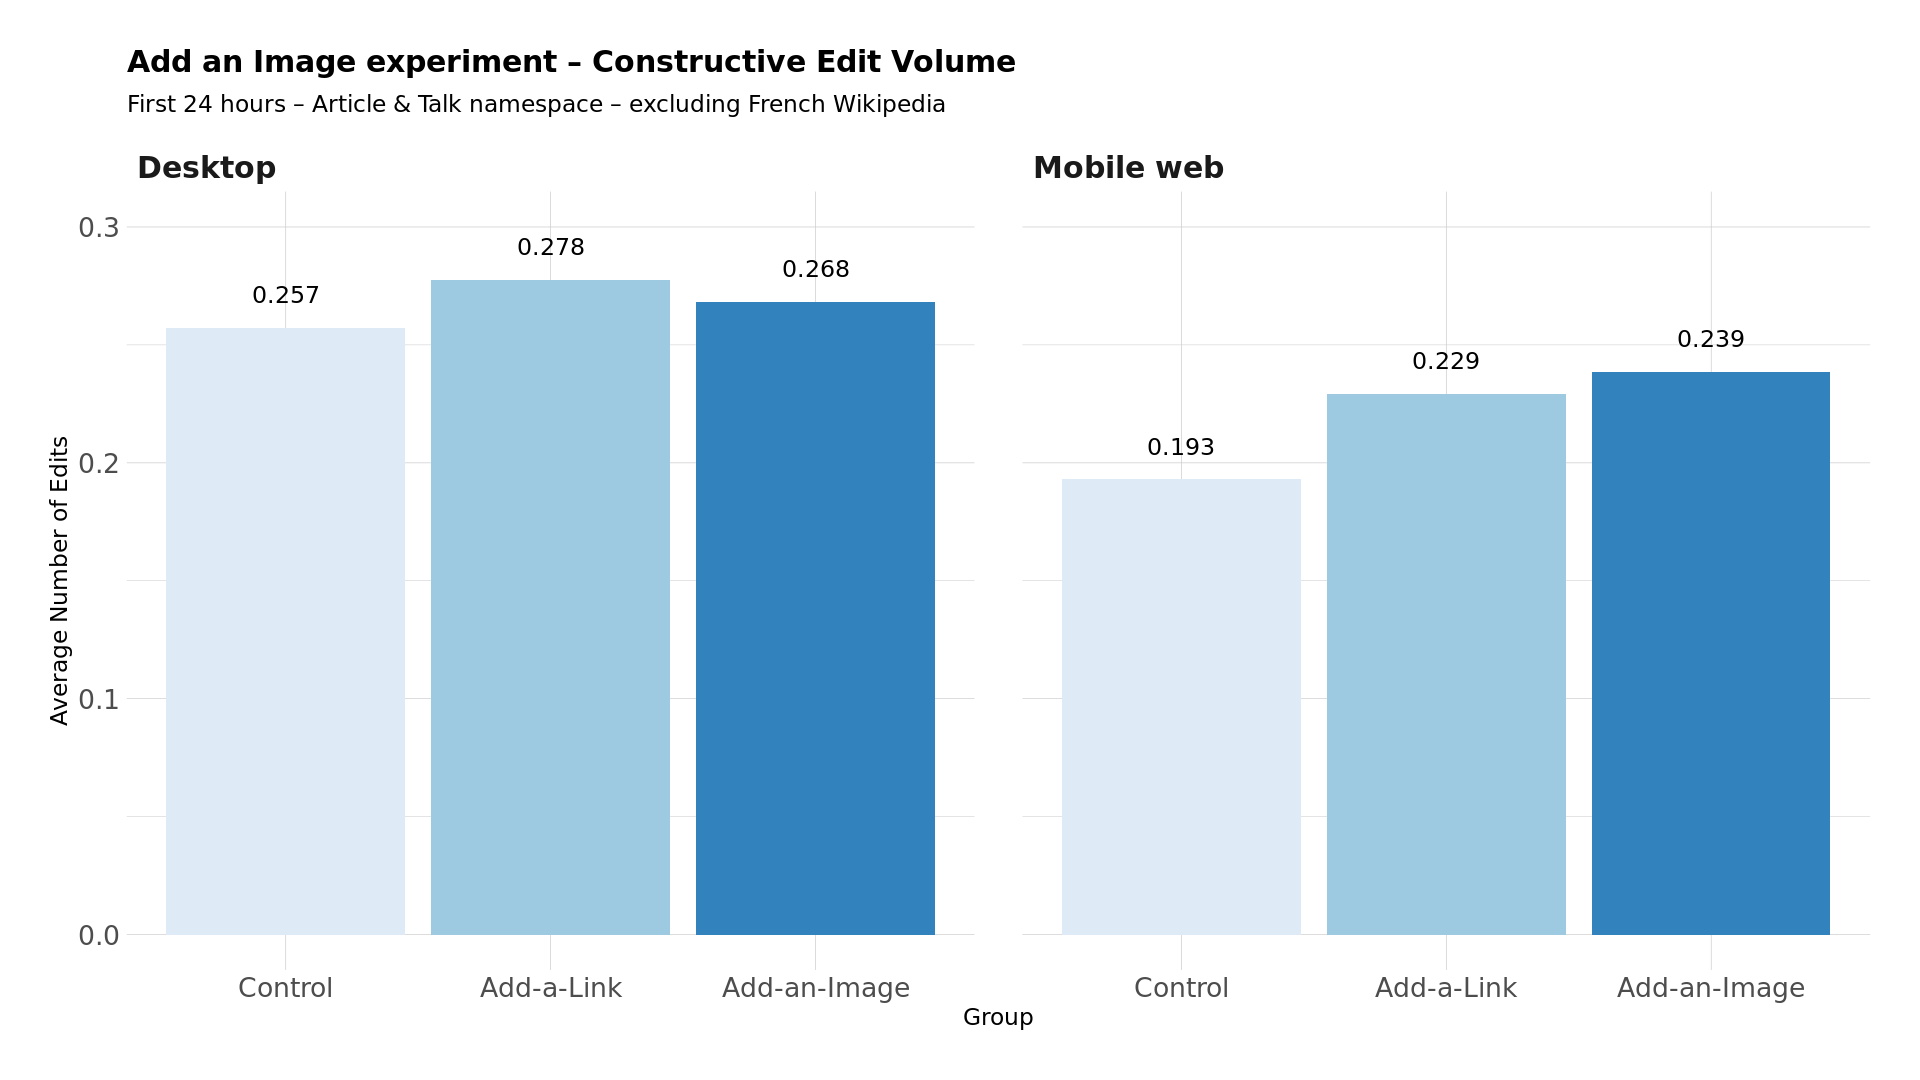

In [54]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group) |>
    summarise(geo_mean = exp(mean(log(1 + num_const_article_edits_24hrs))) -1) |>
    ggplot(aes(x = exp_group, y = geo_mean, fill = exp_group)) +
        labs(title = 'Add an Image experiment – Constructive Edit Volume',
             subtitle = 'First 24 hours – Article & Talk namespace – excluding French Wikipedia',
             x = 'Group',
             y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.3)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.014, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-edit-volume-2022-experiment-24hrs.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

`summarise()` has grouped output by 'platform'. You can override using the
`.groups` argument.


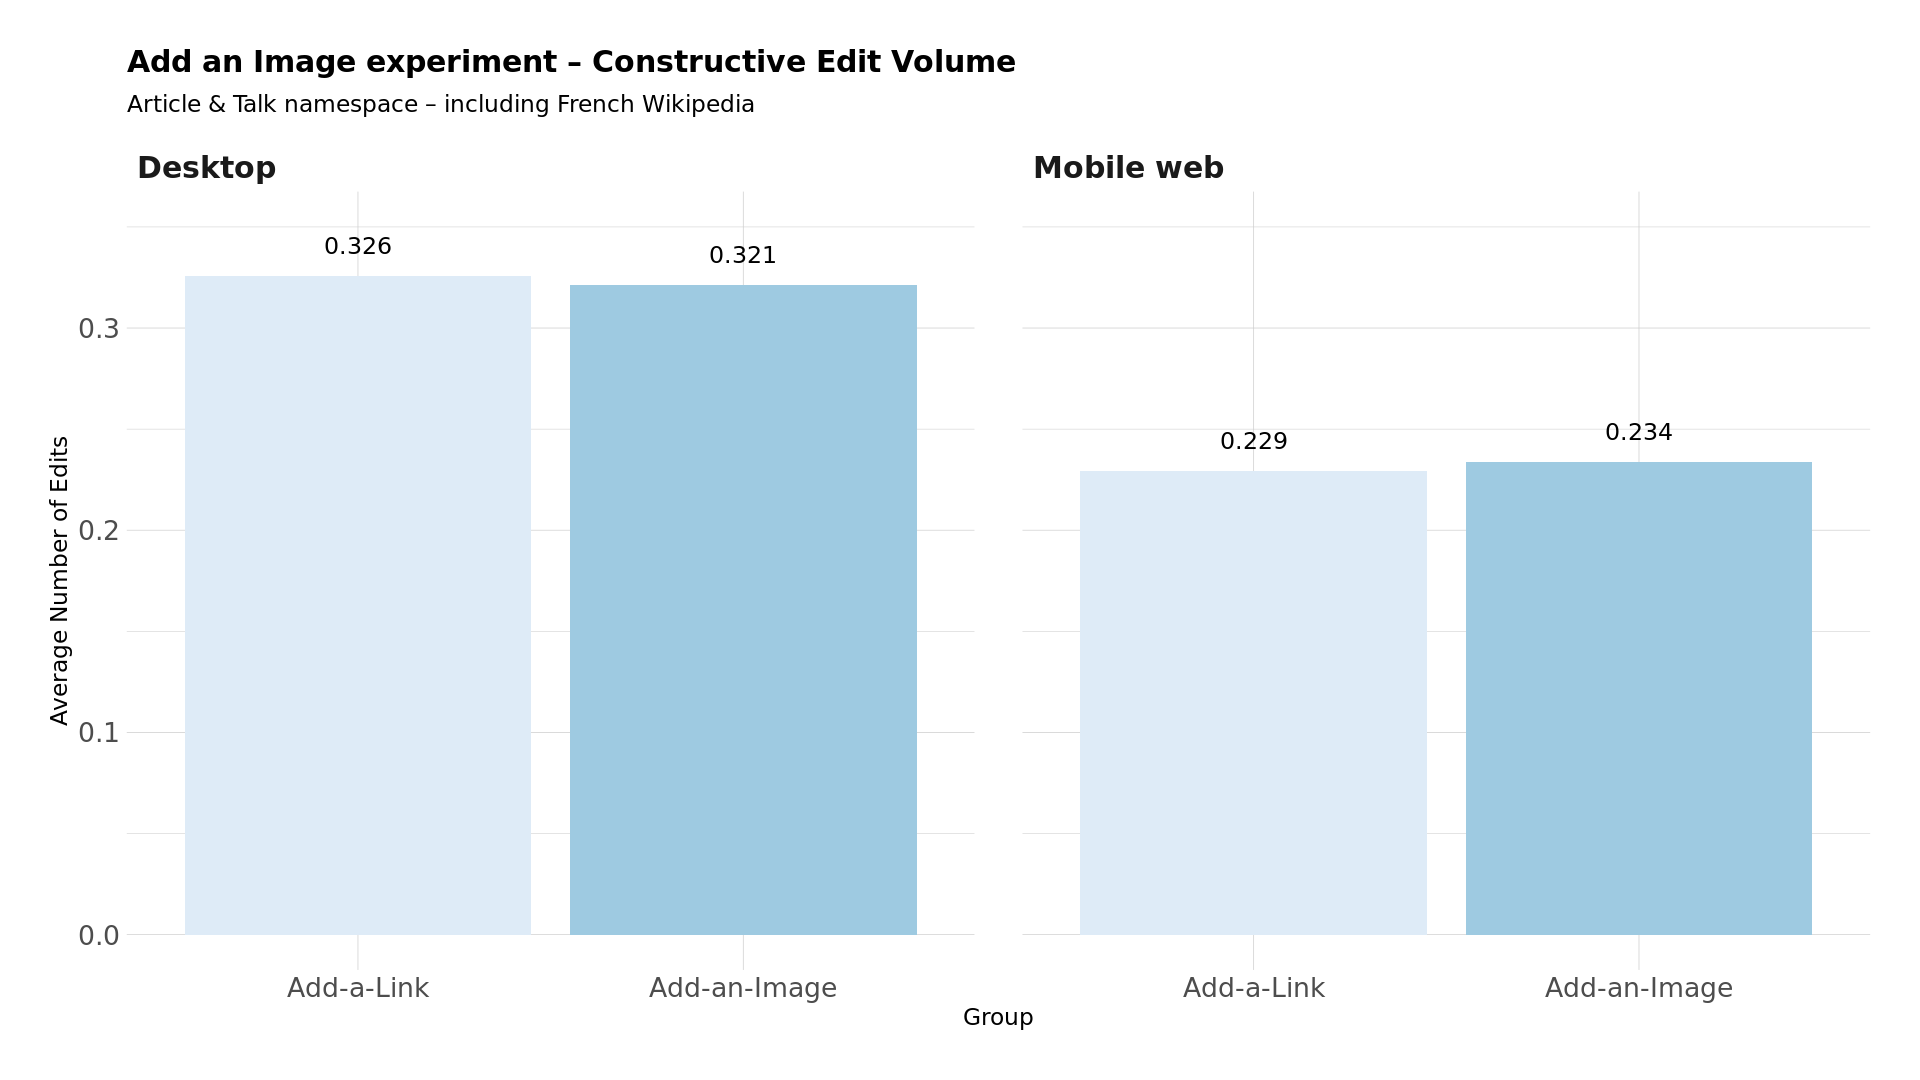

In [57]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
user_edit_data |>
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group) |>
    summarise(geo_mean = exp(mean(log(1 + num_const_article_edits_24hrs))) -1) |>
    ggplot(aes(x = exp_group, y = geo_mean, fill = exp_group)) +
        labs(title = 'Add an Image experiment – Constructive Edit Volume',
             subtitle = 'Article & Talk namespace – including French Wikipedia',
             x = 'Group',
             y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.35)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.015, size = 5) +
        facet_grid(. ~ platform)
#ggsave(
#    'add-an-image-article-namespace-constructive-edit-volume-2022-experiment-structured-tasks-24hrs.png',
#    path = 'graphs',
#    width = 16, height = 9, units = "in", dpi = "print", bg = "white")